In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils
from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel

torch.Size([1, 3, 32, 32]) tensor([0])
tensor([[[[ 1.1859,  1.2018,  1.1700,  ..., -0.1795, -0.2271, -0.3065],
          [ 1.0906,  1.1065,  1.0747,  ..., -0.2113, -0.2589, -0.3224],
          [ 1.0430,  1.0747,  1.0589,  ..., -0.2430, -0.3065, -0.3542],
          ...,
          [-0.1478, -0.1001, -0.0843,  ..., -0.3383, -0.4018, -0.4494],
          [-0.1478, -0.1160, -0.1001,  ..., -0.4177, -0.4335, -0.4812],
          [-0.1636, -0.1319, -0.1319,  ..., -0.4971, -0.5288, -0.5923]],

         [[ 1.7435,  1.7597,  1.7274,  ...,  0.9205,  0.8882,  0.8398],
          [ 1.6629,  1.6790,  1.6467,  ...,  0.9044,  0.8882,  0.8560],
          [ 1.6467,  1.6951,  1.6790,  ...,  0.8882,  0.8560,  0.8237],
          ...,
          [ 0.7753,  0.8398,  0.8560,  ...,  1.0173,  0.9689,  0.9366],
          [ 0.7753,  0.8237,  0.8398,  ...,  0.9366,  0.9205,  0.9044],
          [ 0.7753,  0.8075,  0.8075,  ...,  0.8398,  0.8075,  0.7430]],

         [[ 2.0005,  2.0606,  2.0606,  ...,  1.4746,  1.4596,  

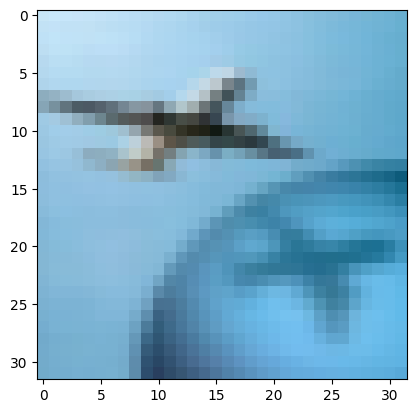

In [ ]:
# load CIFAR10
download = False
dataset_class = datasets.CIFAR10
cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                         std=[0.247, 0.243, 0.261])
])

# dataset_transform = transforms.Compose(cifar10_transform)
cifar10_train = dataset_class('data/CIFAR10', train=True, download=download, transform=cifar10_transform)
cifar10_test = dataset_class('data/CIFAR10', train=False, download=download, transform=cifar10_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(cifar10_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    d = data[0].permute(1, 2, 0).numpy()
    # denomalrize
    d = d * [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465]
    plt.imshow(d)
    plt.show()
    break

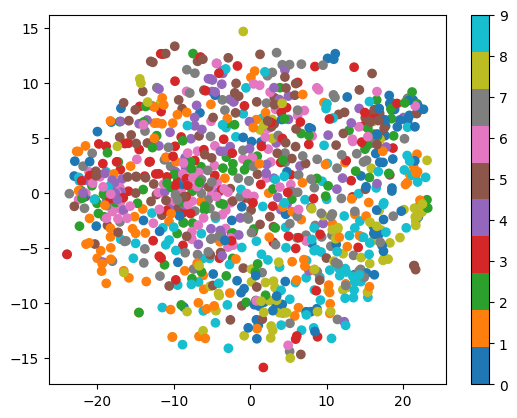

In [6]:
# plot tsne over cifar10 on raw data
# get the data
data = []
labels = []
for i, (d, l) in enumerate(cifar10_train_loader):
    data.append(d[0].numpy().flatten())
    labels.append(l.item())
    if i >= 1000:
        break

data = np.array(data)
labels = np.array(labels)

# tsne
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10')
# color bar
plt.colorbar()
plt.show()

# CNN model for classification

In [36]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.features = nn.Sequential(
            # First block: 32 filters
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # output: 32 x 16 x 16

            # Second block: 64 filters
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # output: 64 x 8 x 8

            # Third block: 128 filters
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # output: 128 x 4 x 4
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.classifier(x)
        return x
    
# train the model
model = CIFAR10_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 128
cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=True)

all_losses = []
for epoch in range(10):
    model.train()
    for i, (data, target) in enumerate(tqdm(cifar10_train_loader)):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        all_losses.append(loss.item())
        # if i % 100 == 0:
            # print(f'Epoch {epoch}, Loss: {loss.item()}')

plt.plot(all_losses)

# test the model
model.eval()
correct = 0
total = 0
for i, (data, target) in enumerate(cifar10_test_loader):
    output = model(data)
    _, predicted = torch.max(output, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

print(f'Accuracy: {correct/total}')


  0%|          | 0/391 [00:00<?, ?it/s]

  6%|▌         | 24/391 [00:05<01:23,  4.38it/s]


KeyboardInterrupt: 

(1280, 2048)
(1280,)


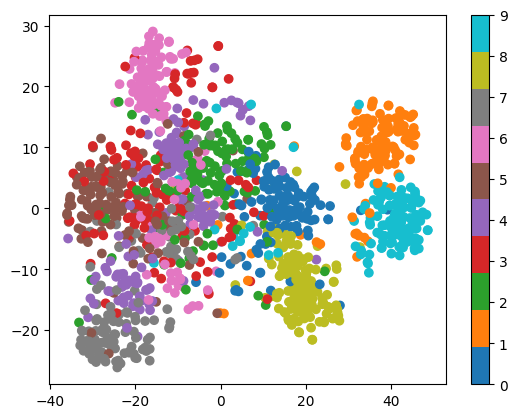

In [39]:
# tsne the representation
data = []
labels = []
for i, (d, l) in enumerate(cifar10_train_loader):
    with torch.no_grad():
        rep = model.features(d).detach().view(-1, 128 * 16).tolist()
        # print(rep)
    data.extend(rep)
    # data.append(model.get_representation(d).detach().numpy().flatten())
    # print(l)
    labels.extend(l.tolist())
    if i >= 9:
        break

data = np.array(data)
print(data.shape)
labels = np.array(labels)
print(labels.shape)

# tsne
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10')
# color bar
plt.colorbar()
plt.show()

100%|██████████| 391/391 [00:50<00:00,  7.78it/s]


(1280, 4096)


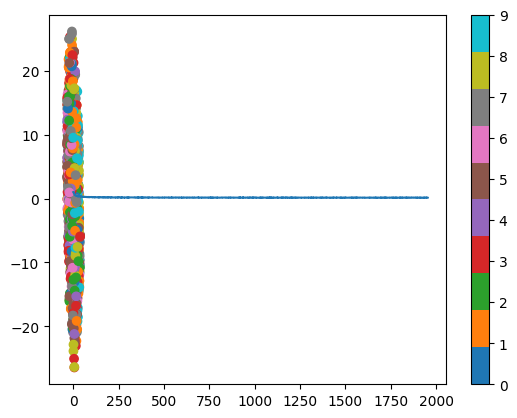

In [40]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder: reduce spatial dimensions and increase feature channels
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # [B, 64, 16, 16]
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [B, 128, 8, 8]
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # [B, 256, 4, 4]
            nn.ReLU(inplace=True)
        )
        # Decoder: reconstruct the image from the latent representation
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 128, 8, 8]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # [B, 64, 16, 16]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # [B, 3, 32, 32]
            # nn.Sigmoid()  # output values in [0, 1]
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# train the autoencoder
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 128
cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=True)

all_losses = []
for epoch in range(5):
    model.train()
    for i, (data, target) in enumerate(tqdm(cifar10_train_loader)):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        all_losses.append(loss.item())
        # if i % 100 == 0:
            # print(f'Epoch {epoch}, Loss: {loss.item()}')

plt.plot(all_losses)

# tsne
data = []
labels = []

model.eval()
for i, (d, l) in enumerate(cifar10_train_loader):
    with torch.no_grad():
        rep = model.encoder(d).detach().view(-1, 256 * 4 * 4).tolist()
    data.extend(rep)
    labels.extend(l.tolist())
    if i >= 9:
        break

data = np.array(data)
print(data.shape)
labels = np.array(labels)


# tsne
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10')
# color bar
plt.colorbar()
plt.show()

